In [1]:
import sys
import os
import requests
import datetime
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))

import time
import talib
import sqlite3 as sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from util.util import get_ucodes
from pypfopt import risk_models, expected_returns, efficient_frontier, plotting, objective_functions

path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')

In [2]:
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()

ucodes = get_ucodes()
data = {}
ucodes1 = ['2800.HK', '2828.HK', '2823.HK', 'spy', 'vti', 'qqq', 'shy', 'tlt'] # '3188.HK', 'voo', 'tqqq'
ucodes2 = ['hsi', 'hsce', 'ssec', '000016.SS', 'xin9x000', 'csi300', 'sp500', 'ixic', 'shy', 'tlt']
ucodes2 = ['hsi', 'hsce', 'ssec', 'sp500', 'ixic', 'shy', 'tlt']
ucodes2 = ['hsi', 'hsce', 'ssec', 'sp500', 'ixic']
for ucode in ucodes2:
    if '.HK' in ucode:
        ucode = ucode.replace('.HK', '').zfill(5)
    if '.SS' in ucode or '.SZ' in ucode:
        ucode = ucode.replace('.SS', '').replace('.SZ', '').zfill(6)
    
    #
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC) AS t 
                            ORDER BY t.stime """.format(ucode)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
    data[ucode].index = pd.to_datetime(data[ucode].sdate)
    print(f"{ucode}:   {data[ucode].index[0]} ~ {data[ucode].index[-1]}  {data[ucode].shape}")
conn.close()

hsi:   1986-12-31 00:00:00 ~ 2021-08-04 00:00:00  (8506, 9)
hsce:   1993-07-15 00:00:00 ~ 2021-08-04 00:00:00  (6869, 9)
ssec:   1997-07-02 00:00:00 ~ 2021-08-04 00:00:00  (5839, 9)
sp500:   1927-12-30 00:00:00 ~ 2021-08-04 00:00:00  (19654, 9)
ixic:   1971-02-05 00:00:00 ~ 2021-08-04 00:00:00  (12371, 9)


In [3]:
data_all = []
nmll = []
for k, df in data.items():
    data_all.append(df['last'])
    nmll.append(k)
df2 = pd.concat(data_all, axis=1)
df2 = df2.dropna()
df2.columns = nmll
print(f"{df2.index[0]} ~ {df2.index[-1]}  {df2.shape}")

1997-07-03 00:00:00 ~ 2021-08-04 00:00:00  (5473, 5)


In [4]:
start_year = list(dict.fromkeys(df2.index.year.values))[1]

相關系數 1998年起


,hsi,hsce,ssec,sp500,ixic
hsi,1.000000,0.879406,0.800562,0.760341,0.714125
hsce,0.879406,1.000000,0.817960,0.453456,0.407163
ssec,0.800562,0.817960,1.000000,0.533359,0.494689
sp500,0.760341,0.453456,0.533359,1.000000,0.985405
ixic,0.714125,0.407163,0.494689,0.985405,1.000000


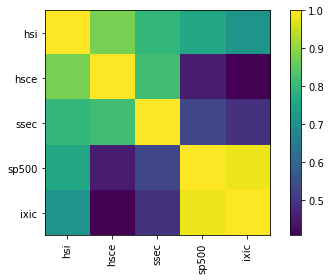

In [5]:
# 相關系數
print(f'相關系數 {start_year}年起')
plotting.plot_covariance(df2.corr(), plot_correlation=False)
df2.corr()

年度標準差(風險)  1998年起
hsi      26.025929
hsce     41.213868
ssec     41.963038
sp500    16.128973
ixic     28.135144
dtype: float64
年度收益率(回報)


,Date,hsi,hsce,ssec,sp500,ixic
1,1998-01-01 ~ 1998-12-31,-1.766968,-43.118525,-6.369991,26.084113,35.933930
2,1999-01-01 ~ 1999-12-31,72.920846,17.110049,21.385409,19.246804,82.825118
3,2000-01-01 ~ 2000-12-31,-11.581508,-22.027142,47.434574,-5.655201,-36.680770
4,2001-01-01 ~ 2001-12-31,-23.122827,8.610038,-22.058085,-9.526444,-13.290519
5,2002-01-01 ~ 2002-12-31,-20.763879,9.707247,-15.206153,-24.999360,-34.954204
6,2003-01-01 ~ 2003-12-31,33.753821,143.250662,14.467416,22.068576,45.133411
7,2004-01-01 ~ 2004-12-31,10.639936,-12.204791,-16.048321,9.478752,8.554430
8,2005-01-01 ~ 2005-12-31,5.912966,13.465805,-6.575374,5.070493,4.623645
9,2006-01-01 ~ 2006-12-31,31.346332,85.644138,126.550205,11.373745,6.707876
10,2007-01-01 ~ 2007-12-31,36.678186,54.541849,93.744750,4.240875,9.009021


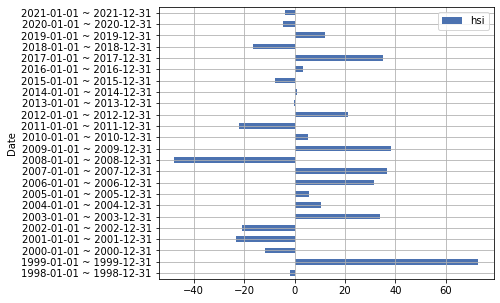

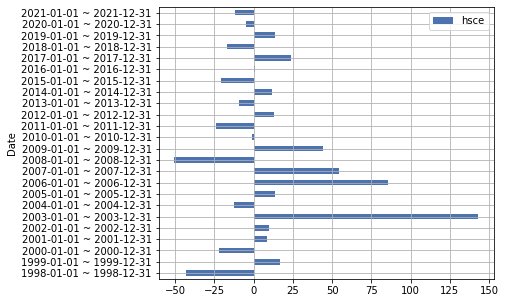

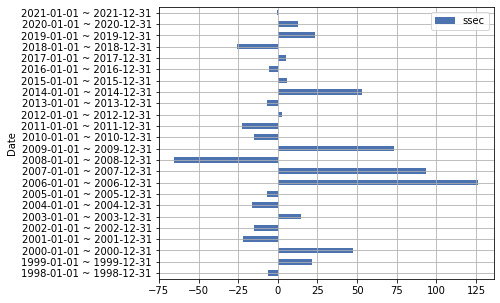

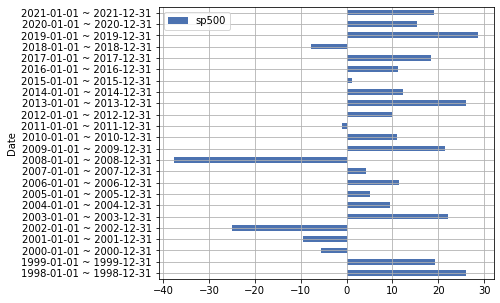

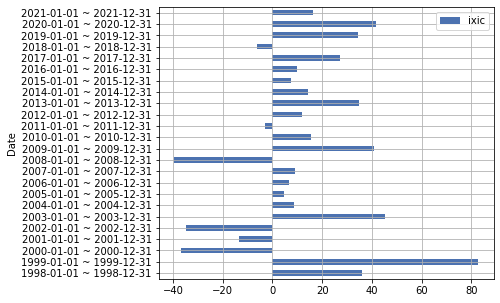

In [6]:
# 年度
df3_1 = df2.copy(deep=True)
df3 = pd.DataFrame(columns=['Date']+df3_1.columns.to_list())
for year in range(start_year, 2022, 1):
    df3_2 = df3_1[f'{year}-01-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df3.loc[df3.shape[0]+1] = [f'{year}-01-01 ~ {year}-12-31']+df3_2.iloc[-1].to_list()
print(f'年度標準差(風險)  {start_year}年起')
print(df3.std())
print('年度收益率(回報)')
for k in ucodes2:
    ax = df3.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
df3

In [7]:
# 累計 年化收益率
df4 = pd.DataFrame(columns=['Date']+df3_1.columns.to_list())
df4['Date'] = df3['Date']
for code in data.keys():
    annualized_total_return = 1
    annualized_total_returns = []
    for v in df3[code]:
        no_year = df3[code].shape[0]
        annualized_total_return = annualized_total_return * (1+(v/100))
        annualized_total_returns.append((annualized_total_return-1))
    df4[code] = annualized_total_returns
    
print('累計 年化收益率')
df4

累計 年化收益率


,Date,hsi,hsce,ssec,sp500,ixic
1,1998-01-01 ~ 1998-12-31,-0.017670,-0.431185,-0.063700,0.260841,0.359339
2,1999-01-01 ~ 1999-12-31,0.698654,-0.333861,0.136532,0.503513,1.485214
3,2000-01-01 ~ 2000-12-31,0.501924,-0.480592,0.675641,0.418486,0.573618
4,2001-01-01 ~ 2001-12-31,0.154637,-0.435871,0.306026,0.283355,0.364476
5,2002-01-01 ~ 2002-12-31,-0.085111,-0.381110,0.107430,-0.037476,-0.112466
6,2003-01-01 ~ 2003-12-31,0.223700,0.505455,0.267647,0.174940,0.288109
7,2004-01-01 ~ 2004-12-31,0.353900,0.321717,0.064211,0.286309,0.398299
8,2005-01-01 ~ 2005-12-31,0.433956,0.499697,-0.005765,0.351532,0.462952
9,2006-01-01 ~ 2006-12-31,0.883449,1.784100,1.252441,0.505251,0.561085
10,2007-01-01 ~ 2007-12-31,1.574264,3.302600,3.363986,0.569087,0.701723


半年度標準差(風險)  1998年起
hsi      14.666077
hsce     24.183337
ssec     23.758163
sp500    10.133097
ixic     15.230805
dtype: float64
半年度收益率(回報)


,Date,hsi,hsce,ssec,sp500,ixic
1,1998-01-01 ~ 1998-06-30,-17.085460,-38.210039,9.728114,16.044905,18.858053
2,1998-07-01 ~ 1998-12-31,14.158105,-12.186195,-14.186987,7.458873,14.411296
3,1999-01-01 ~ 1999-06-30,37.953973,59.748040,50.062135,11.775099,21.651233
4,1999-07-01 ~ 1999-12-31,19.581260,-26.845197,-12.476652,5.265163,47.276200
5,2000-01-01 ~ 2000-06-30,-5.371345,-8.593183,37.097963,3.943057,1.651084
6,2000-07-01 ~ 2000-12-31,-6.384133,-14.239248,9.381548,-10.156920,-38.112140
7,2001-01-01 ~ 2001-06-30,-12.289290,43.560950,5.446244,-4.589059,-5.729847
8,2001-07-01 ~ 2001-12-31,-13.296878,-24.321458,-25.876584,-5.948393,-7.172087
9,2002-01-01 ~ 2002-06-30,-9.430750,19.291200,7.531500,-15.581104,-28.949002
10,2002-07-01 ~ 2002-12-31,-11.622737,-8.224206,-20.788262,-7.246149,-1.346269


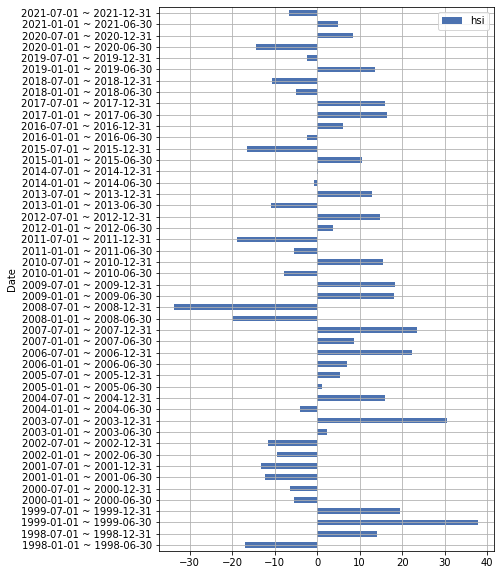

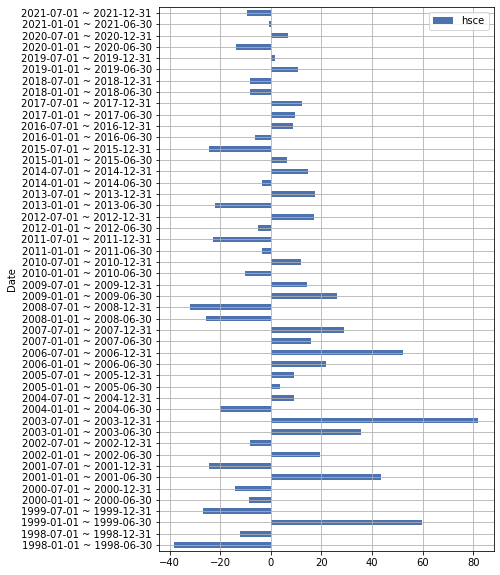

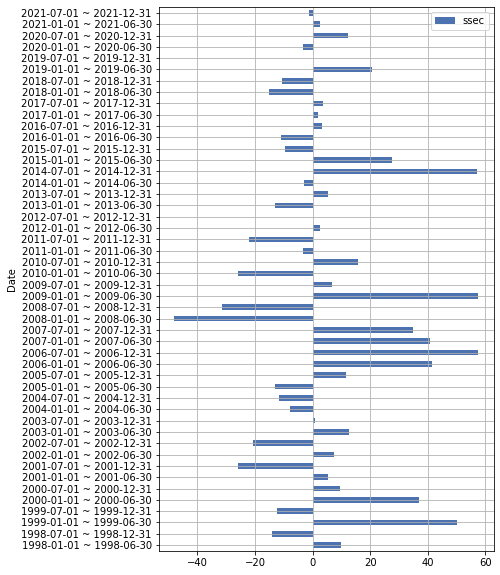

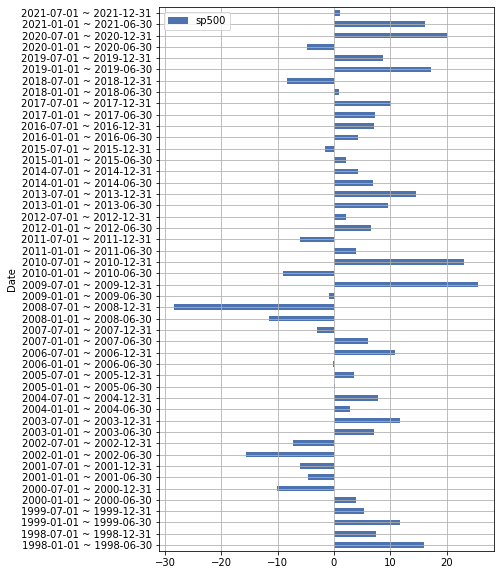

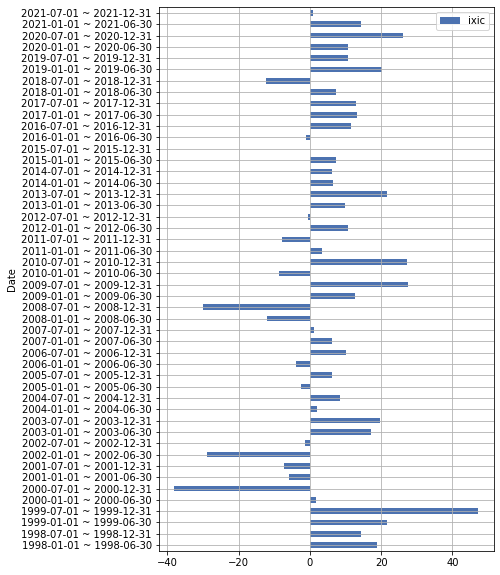

In [8]:
# 半年度
df5_1 = df2.copy(deep=True)
df5 = pd.DataFrame(columns=['Date']+df5_1.columns.to_list())
for year in range(start_year, 2022, 1):
    #
    df5_2 = df5_1[f'{year}-01-01': f'{year}-06-30'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-01-01 ~ {year}-06-30']+df5_2.iloc[-1].to_list()
    #
    df5_2 = df5_1[f'{year}-07-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-07-01 ~ {year}-12-31']+df5_2.iloc[-1].to_list()
print(f'半年度標準差(風險)  {start_year}年起')
print(df5.std())

for k in ucodes2:
    ax1 = df5.plot.barh(x='Date', y=k, figsize=(6,8*1.25), grid=True)

print('半年度收益率(回報)')
df5

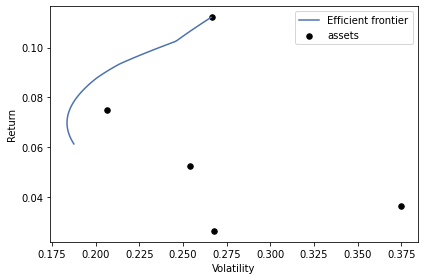

Expected annual return: 8.6%
Annual volatility: 19.7%
Sharpe Ratio: 0.33
(0.08576921538002902, 0.19712421963734209, 0.3336435040860401)
OrderedDict([('hsi', 0.01337), ('hsce', 0.06536), ('ssec', 0.16731), ('sp500', 0.27681), ('ixic', 0.47716)])


d:\pycharmprojects\scrapy-001\venv\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:253: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


In [9]:
df6 = df2.copy(deep=True)

expected_return = expected_returns.mean_historical_return(df6)
cov_matrix1 = risk_models.CovarianceShrinkage(df6).ledoit_wolf()
cov_matrix2 = risk_models.sample_cov(df6)

ef = efficient_frontier.EfficientFrontier(expected_return, cov_matrix2, weight_bounds=(0,1), verbose=False)
ef.add_objective(objective_functions.L2_reg)
# ef.min_volatility()
# ef.add_constraint(lambda w: w[0] >= 0.2)
# ef.add_constraint(lambda w: w[2] == 0.15)
# ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)
fig, ax = plt.subplots()
# risk_range = np.linspace(0.03, 0.90, 100)
# plotting.plot_efficient_frontier(ef, ax=ax, ef_param="risk", ef_param_range=risk_range, show_assets=True, showfig=True)
plotting.plot_efficient_frontier(ef, ax=ax)
plt.show()

weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")
print(ef.portfolio_performance(verbose=True))
print(cleaned_weights)

標準差 1998年起      (5473, 5)


,hsi,hsce,ssec,sp500,ixic
hsi,0.071649,0.078001,0.024449,0.013861,0.017469
hsce,0.078001,0.140505,0.035763,0.014867,0.017665
ssec,0.024449,0.035763,0.064569,0.003913,0.004867
sp500,0.013861,0.014867,0.003913,0.042559,0.048812
ixic,0.017469,0.017665,0.004867,0.048812,0.070931


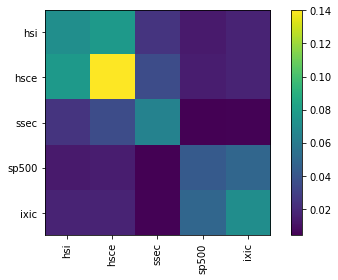

In [10]:
print(f'標準差 {start_year}年起      {df6.shape}')
plotting.plot_covariance(cov_matrix2, plot_correlation=False, show_tickers=True)
cov_matrix2